# Quadrupolar Coupling Demo PULSEE

# Imports

In [1]:
import numpy as np
import pandas as pd
from pulsee.operators import * 
from pulsee.simulation import *
import qutip as qt
import matplotlib.pyplot as plt

# Parameters

In [2]:
qn = 3/2
gr = 1.
b0 = 1.
e2qQ = 0.5

spin_par = {'quantum number' : qn,
			'gamma/2pi' : gr}

zeem_par = {'field magnitude' : b0,
			'theta_z' : 0,
			'phi_z' : 0}

In [3]:
etas = np.linspace(0, 1, 2)
# etas = [0]

# Simulation
Define simulation code which we will run with different solvers:

In [4]:
def simulate(solver):

    # Fourier transforms for each eta
    fts = []

    for eta in etas:
        quad_par = {'coupling constant' : e2qQ,
                    'asymmetry parameter' : eta,
                    'alpha_q' : 0.,
                    'beta_q' : 0.,
                    'gamma_q' : 0.}

        b1 = 1e-1*b0
        
        mode = pd.DataFrame([(1, b1, 0., math.pi/2, 0)], 
                            columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

        spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
                                            zeem_par=zeem_par, initial_state='canonical', temperature=1e-3)
        
        ix, iy, iz = qt.spin_J_set(3 / 2)
        print(np.round(dm_initial.full(), 3))
        opts = Options(atol=1e-10, rtol=1e-10, rhs_reuse=False, nsteps=16000)
        dm_evolved = evolve(spin, h_unperturbed, dm_initial, solver=solver, \
                            mode=mode, pulse_time = 1 / (4 * math.sqrt(3) *  gr * b1), \
                            picture='IP', n_points=10, opts=opts)

        print(np.round(dm_evolved.full(), 3))
        t, FID = FID_signal(spin, h_unperturbed, dm_evolved, acquisition_time=1000, \
                            T2=50, reference_frequency=0, n_points=5)


        f, ft = fourier_transform_signal(FID, t, padding=0)
        fts.append([eta, f, ft, t, FID])
    return fts

# Plots

Run simulations with Magnus solve

In [5]:
fts_magnus = simulate('magnus')

[[0.267+0.j 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.257+0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.245+0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.231+0.j]]
[[ 0.267+0.j    -0.001+0.j    -0.   -0.j    -0.   +0.j   ]
 [-0.001-0.j     0.257+0.j     0.001+0.j    -0.   +0.j   ]
 [-0.   +0.j     0.001-0.j     0.245+0.j    -0.   -0.001j]
 [-0.   -0.j    -0.   -0.j    -0.   +0.001j  0.231+0.j   ]]
[[ 0.267+0.j  0.   +0.j -0.001+0.j  0.   +0.j]
 [ 0.   +0.j  0.257+0.j  0.   +0.j -0.001+0.j]
 [-0.001+0.j  0.   +0.j  0.245+0.j  0.   +0.j]
 [ 0.   +0.j -0.001+0.j  0.   +0.j  0.231+0.j]]
[[ 0.267+0.j    -0.001+0.j    -0.001-0.j     0.   -0.j   ]
 [-0.001-0.j     0.257+0.j     0.001+0.j    -0.001+0.j   ]
 [-0.001+0.j     0.001-0.j     0.245+0.j    -0.   -0.001j]
 [ 0.   +0.j    -0.001-0.j    -0.   +0.001j  0.231+0.j   ]]


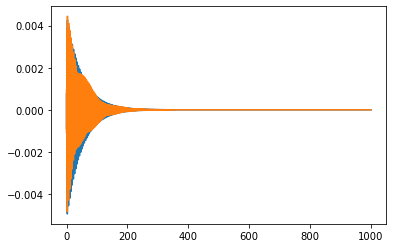

In [6]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_magnus: 
	plt.plot(t, np.real(fid))

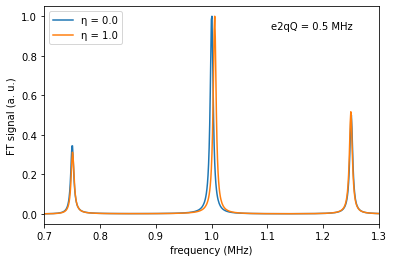

In [7]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_magnus:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.7, 1.3)
plt.show()

Plot & solve mesolve solution QuTiP's [master equation solver](https://qutip.org/docs/latest/modules/qutip/mesolve.html#mesolve)::

In [8]:
fts_mesolve = simulate('mesolve')

[[0.267+0.j 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.257+0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.245+0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.231+0.j]]
[[ 0.267-0.j    -0.001-0.j     0.   -0.j    -0.   -0.j   ]
 [-0.001+0.j     0.257+0.j     0.001-0.j     0.   -0.j   ]
 [ 0.   +0.j     0.001+0.j     0.245-0.j    -0.   +0.001j]
 [-0.   +0.j     0.   +0.j    -0.   -0.001j  0.231+0.j   ]]
[[ 0.267+0.j  0.   +0.j -0.001+0.j  0.   +0.j]
 [ 0.   +0.j  0.257+0.j  0.   +0.j -0.001+0.j]
 [-0.001+0.j  0.   +0.j  0.245+0.j  0.   +0.j]
 [ 0.   +0.j -0.001+0.j  0.   +0.j  0.231+0.j]]
[[ 0.267-0.j    -0.001-0.j    -0.001-0.j     0.   +0.j   ]
 [-0.001+0.j     0.257+0.j     0.001-0.j    -0.001-0.j   ]
 [-0.001+0.j     0.001+0.j     0.245+0.j    -0.   +0.001j]
 [ 0.   -0.j    -0.001+0.j    -0.   -0.001j  0.231-0.j   ]]


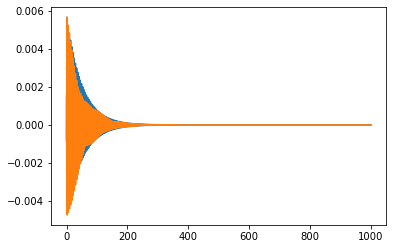

In [9]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_mesolve: 
	plt.plot(t, np.imag(fid))

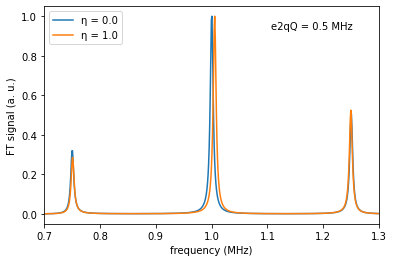

In [10]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_mesolve:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.7, 1.3)
plt.show()

One must experiment with the pulse duration to find the exact $\pi/2$ pulse. This is hard because of the presence of the Zeeman term in the Hamiltonian. The spins are rotating during the evolution of the pulse with respect to the applied field. This is why the peaks for the $\eta = 0$ case are not exacly symmetric. 

Simulate with exact diagonalization approach:

In [11]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : 0.,
				'gamma_q' : 0.}

	spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical', temperature=1e-3)

    
    
	t = np.linspace(0, 1000, 5*1000) # 50 second acquisition time, 1000 data points

	ix, iy, iz = qt.spin_J_set(3 / 2)
	rot_dm = apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, par=True, T2=50)

	FID = e_ops[0]

	f, ft = fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft, t, FID])


Plot exact diagonalization solution:

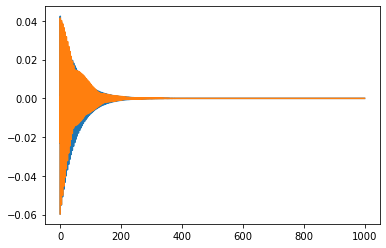

In [12]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_ed: 
	plt.plot(t, np.imag(fid))

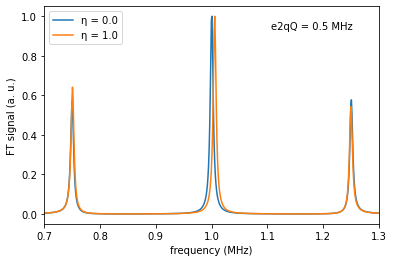

In [13]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_ed:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.7, 1.3)
plt.show()

Because of the instatenous pulse, we have an exact $\pi/2$ pulse and the peaks for the $\eta = 0$ case are symmetric around the central peak. 

Simulate with exact diagonalization approach \& 2 different stretched exponential decays:

In [14]:
etas = [0]
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : 0.,
				'gamma_q' : 0.}

	spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical', temperature=1e-3)

    
    
	t = np.linspace(0, 1000, 5*1000) # 50 second acquisition time, 1000 data points

	ix, iy, iz = qt.spin_J_set(3 / 2)
	rot_dm = apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, par=True, T2=[lambda t: np.exp(-(t/50)**1.5), lambda t: np.exp(-(t/50)**2)])

	FID = e_ops[0]

	f, ft = fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft, t, FID])


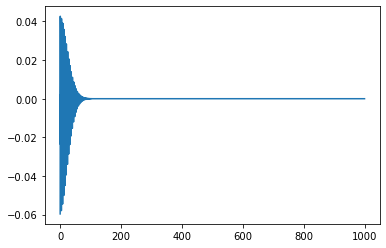

In [15]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_ed: 
	plt.plot(t, np.imag(fid))

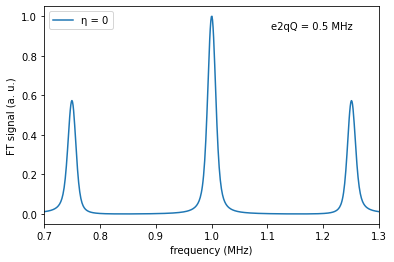

In [16]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_ed:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.7, 1.3)
plt.show()

The peaks here are broadened by two stetched exponentials $\exp(-(t/T_2)^\beta)$, where $T_2 = 50 \mu$s and $\beta = \{1.5, 2\}$.